In [1]:
import numpy as np 
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import rcParams 
from astroML.plotting.mcmc import convert_to_stdev
import celerite
from celerite import terms
from astropy.table import Table
from astropy.table import vstack
from astropy.table import Column
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18
import os
import scipy

The results from running MCMC on S82 are in 

    '../data_products/Simulated_DRW_Kozlowski/SDSS/thursday_work/'

In [2]:
# read in the files  with logL evaluated on a grid
# and calculate the expectation value .... 

simulation = 'SDSS'
resDir  = '../data_products/Simulated_DRW_Kozlowski/'+simulation+'/thursday_work/'# 




In [3]:
# The grid is uniform in log10(rho), but not in actual rho ...
t_exp = 8*365
rho_min, rho_max,  n_rho = 0.001, 15, 100
rho_grid = np.logspace(np.log10(rho_min), np.log10(rho_max), n_rho)
taus = rho_grid  * t_exp

# 'problematic timescales '
m = (-2.2<np.log10(rho_grid)) * (np.log10(rho_grid) < -1.5)
print(taus[m])
print(np.arange(len(rho_grid))[m])

[ 18.4865092   20.37218687  22.45020915  24.74019573  27.26376761
  30.04475115  33.10940309  36.48665844  40.20840366  44.3097777
  48.82950381  53.81025513  59.29905756  65.34773379  72.01339257
  79.35896793  87.45381332]
[19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35]


In [4]:
# Check which files in the results 
# directory end with .npy 
files = os.listdir(resDir)
m = [f.endswith('.npy') for f in files]
resFiles =  np.asarray(files)[np.array(m)]
N = 60 
prior = 'Jeff2'
Nf  = len(resFiles)
loglike_results = {'lc_name': np.zeros_like(resFiles),
                  'sigma_exp':np.zeros(Nf, dtype=float),
                  'tau_exp':np.zeros(Nf, dtype=float),
                 'sigma_MAP':np.zeros(Nf, dtype=float),
                 'tau_MAP':np.zeros(Nf, dtype=float),
                   'sigma_MCMC':np.zeros(Nf, dtype=float),
                   'tau_MCMC':np.zeros(Nf, dtype=float),
                   'rho_in':np.zeros(Nf, dtype=float),
                   'tau_in':np.zeros(Nf, dtype=float),
                  }
print('Using ', len(resFiles), ' files')


for k in range(len(resFiles)) : 
    fname = resFiles[k]
    results = np.load(resDir+fname).item()
    loglike_results['lc_name'][k] = fname[:-9] + '.dat'
    
    iCounter =  int(resFiles[k][len('DRW_rho-'):-len('_087_logP.npy')])
                # corresponds to rho 
    jCounter =  int(resFiles[k][len('DRW_rho-000_'):-len('_logP.npy')])
                # corresponds to N-th iteration 
        
    loglike_results['rho_in'][k] = rho_grid[iCounter]
    loglike_results['tau_in'][k] = results['tau_in']
    
    # read the MCMC results
    loglike_results['sigma_MCMC'][k] = results['sigma_MCMC']
    loglike_results['tau_MCMC'][k] = results['tau_MCMC']
    
    # read the MAP results 
    loglike_results['sigma_MAP'][k] = results['sigma_MAP']
    loglike_results['tau_MAP'][k] = results['tau_MAP']

    # we also store the actual grid....
    sigma_grid = results['sigma_grid']
    tau_grid   = results['tau_grid']

    # find the expectation value ..
    # we are storing log Posterior ...
    logP = results['logP']
    dsigma =  sigma_grid[1] - sigma_grid[0]
    dtau = tau_grid[1] - tau_grid[0]

    p_sigma = np.exp(logP).sum(1)
    p_sigma /= p_sigma.sum() * (dsigma)

    p_tau = np.exp(logP).sum(0)
    p_tau /= p_tau.sum() * (dtau)

    # find it with trapezoidal rule 
    loglike_results['sigma_exp'][k] = scipy.integrate.trapz(sigma_grid*p_sigma, 
                                                                  dx=dsigma)
    loglike_results['tau_exp'][k] = scipy.integrate.trapz(tau_grid*p_tau, 
                                                                dx=dtau)
print('Done')

# store regardless of prior...
loglike = Table(loglike_results)
fname  = 'loglike_'+prior+'_'+str(int(N))+'_'+simulation+'_MCMC.txt'
print('Saved as ', fname)
loglike.write(fname, format='ascii',overwrite=True)

    

Using  5602  files
Done
Saved as  loglike_Jeff2_60_SDSS_MCMC.txt


In [54]:
#loglike

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log10


Saved as  SDSS_Jeff2_MAP.png


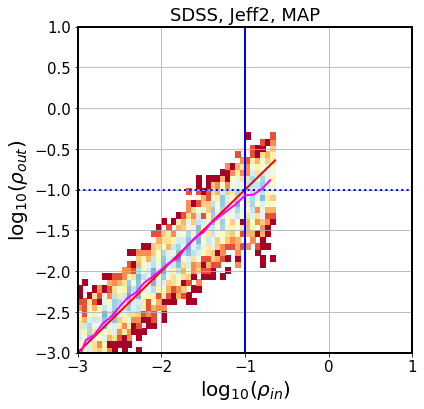

In [13]:
%matplotlib inline
from scipy.stats import binned_statistic_2d

prior='Jeff2'

simulation='SDSS'
N = 60 
fname = 'loglike_'+prior+'_'+str(int(N))+'_'+simulation+'_MCMC.txt'
loglike = Table.read(fname, format='ascii')


t_exp = 8 * 365.0 # days 
for label in ['MAP']:#, 'expectation', 'MCMC']:
    if label is 'MAP':
        rho_in = loglike['rho_in']
        rho_out  = loglike['tau_MAP'] * np.power(10,0.16)/ t_exp
        
    elif label is 'expectation':
        rho_in = loglike['rho_in']
        rho_out  = loglike['tau_exp'] / t_exp
        
    elif label is 'MCMC':
        m1 = loglike['tau_MCMC'] > 1e-100
        m2 = ~np.isinf(loglike['tau_MCMC'])
        m = m1*m2
        rho_in = loglike['rho_in'][m]
        rho_out= loglike['tau_MCMC'][m] / t_exp

    fig,ax = plt.subplots(1,1,figsize=(6,6))
    x = np.log10(rho_in)
    y = np.log10(rho_out)#+0.16

    stats = binned_statistic_2d(x, y, x, statistic='count', bins=40)
    z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
    z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
    z_reduce  =  z_sigma
    z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
    z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
    z_rot_flip = np.flipud(z_rot)
    z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)
    image = ax.pcolormesh(x_edges,y_edges, np.log10(z_masked), 
                             cmap=plt.cm.get_cmap('RdYlBu'))
    # labels...
    ax.set_xlabel(r'$\log_{10}(\rho_{in})$')
    ax.set_ylabel(r'$\log_{10}(\rho_{out})$')

    # lines to guide the eye ...
    ax.grid()
    xlim = ax.get_xlim()
    x_line = np.arange(xlim[0], xlim[1],0.01)
    ax.plot(x_line,x_line, ls='-', lw=2, color='red')
    ax.axhline(-1, ls=':', lw=2, c='blue')
    ax.axvline(-1, ls='-', lw=2, c='blue')

    # calculate the median of log(rho_out)
    # Median of the log(y) is not the log(median(y)) .... 
    min_x, max_x , step_size = xlim[0],xlim[1], 0.1
    mean_x = np.arange(min_x, max_x+step_size , step_size)
    dx = 0.5 * step_size 
    median_y = np.zeros(len(mean_x))

    for j in range(len(median_y)):
        # take points that are within desired x_data limits for each bin
        # i.e. marginalize along y ( stack vertically)
        mask =  ((mean_x[j] - dx) < x)*(x<  (mean_x[j] + dx))
        median_y[j] = np.median(y[mask])

    ax.plot(mean_x[:-1], median_y[:-1], c = 'magenta',lw=2)#, s=50 , edgecolor='black')
    ax.set_title(simulation+', ' +prior+', '+label)
    ax.set_ylim(-3,1)
    ax.set_xlim(-3,1)
    figname = simulation+'_'+prior+'_'+label+'.png'
    plt.savefig(figname, bbox_inches='tight')
    print('Saved as ', figname)

In [14]:
np.sum(np.isnan(rho_in))

0

In [31]:
np.sum(~np.isfinite(y))

1

In [32]:
rho_out[~np.isfinite(y)]

inf
